In [1]:
import os
from os import listdir
from os.path import join
import matplotlib.pyplot as plt
import numpy as np

import torch
from dust3r.inference import make_batches, loss_of_one_batch
from dust3r.losses import *
from dust3r.model import AsymmetricCroCo3DStereo, inf
from dust3r.utils.viz import ReverseImgNorm, get_nonzero_corrs, ReverseCoordNorm

/home/kh775/.conda/envs/c3po/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def viz(view1, view2, pred1, pred2, image_size):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4)) 
    plan = view1["img"].permute(0, 2, 3, 1)[0].cpu().numpy()
    photo = view2["img"].permute(0, 2, 3, 1)[0].cpu().numpy()

    axes[0].imshow(ReverseImgNorm(plan))
    pred = pred2["pts3d_in_other_view"][0].detach().cpu().numpy()
    photo_coords = get_nonzero_corrs(view2["corrs"][0].cpu())
    photo_xs = photo_coords[:,0].numpy()
    photo_ys = photo_coords[:,1].numpy()
    pred = np.stack((pred[photo_ys, photo_xs, 0], pred[photo_ys, photo_xs, 2]), axis=1)
    pred = ReverseCoordNorm(pred, image_size)
    axes[0].scatter(pred[:,0], pred[:,1], s=1, c="red")
    axes[0].set_title("pred")

    axes[1].imshow(ReverseImgNorm(plan))
    gt = get_nonzero_corrs(view1["corrs"][0].cpu()).numpy()
    axes[1].scatter(gt[:,0], gt[:,1], s=1, c="red")
    axes[1].set_title("groundtruth")

    axes[2].imshow(ReverseImgNorm(photo))
    axes[2].scatter(photo_xs, photo_ys, s=1, c="red") 
    axes[2].set_title("photo + correspondence")

    axes[3].imshow(ReverseImgNorm(photo))
    axes[3].set_title("photo")

    plt.tight_layout()
    plt.show()
    plt.close()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

image_size = 512
model = AsymmetricCroCo3DStereo(
    pos_embed='RoPE100', 
    patch_embed_cls='ManyAR_PatchEmbed', 
    img_size=(image_size, image_size), 
    head_type='dpt', 
    output_mode='pts3d', 
    depth_mode=('exp', -inf, inf), 
    conf_mode=('exp', 1, inf), 
    enc_embed_dim=1024, 
    enc_depth=24, 
    enc_num_heads=16, 
    dec_embed_dim=768, 
    dec_depth=12, 
    dec_num_heads=12
)
model.to(device)
criterion = eval("CorrespondenceLoss(L21)")
demo_dir = "demo/"
ckpt_path = join(demo_dir, "ckpt.pth")
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt['model'], strict=False)
del ckpt


/tmp/ipykernel_3569612/3669954968.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


Building Train (heldout)/Test Data loader for dataset
Train (heldout)/Test dataset length: 1


/share/phoenix/nfs06/S9/kh775/C3Po/dust3r/inference.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/share/phoenix/nfs06/S9/kh775/C3Po/dust3r/model.py:223: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/share/phoenix/nfs06/S9/kh775/C3Po/dust3r/inference.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/share/phoenix/nfs06/S9/kh775/C3Po/dust3r/losses.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(array, dtype=torch.float) / (imag

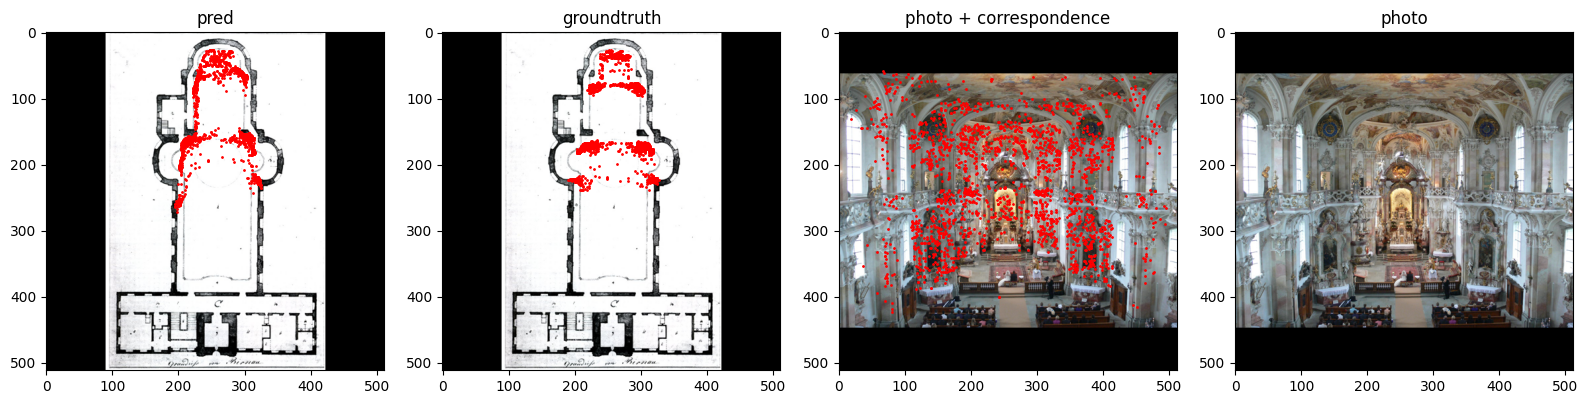

Building Train (heldout)/Test Data loader for dataset
Train (heldout)/Test dataset length: 1


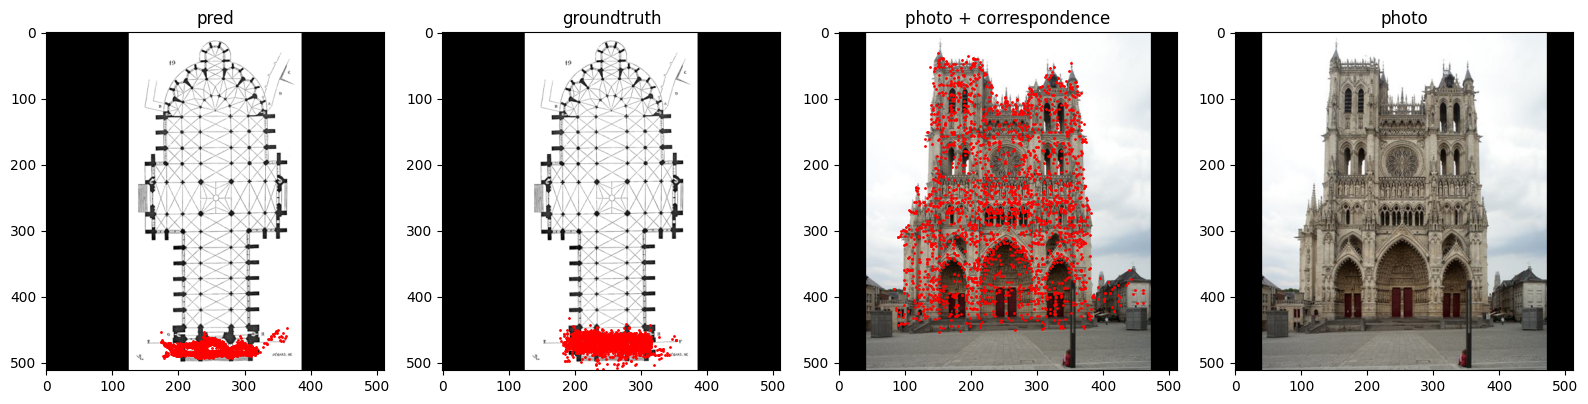

Building Train (heldout)/Test Data loader for dataset
Train (heldout)/Test dataset length: 1


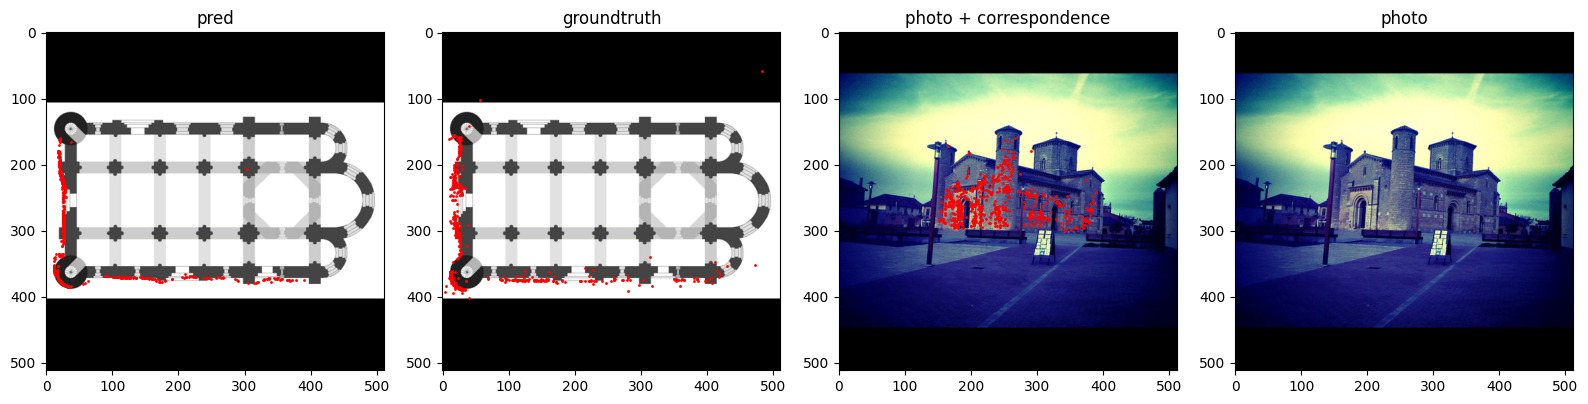

Building Train (heldout)/Test Data loader for dataset
Train (heldout)/Test dataset length: 1


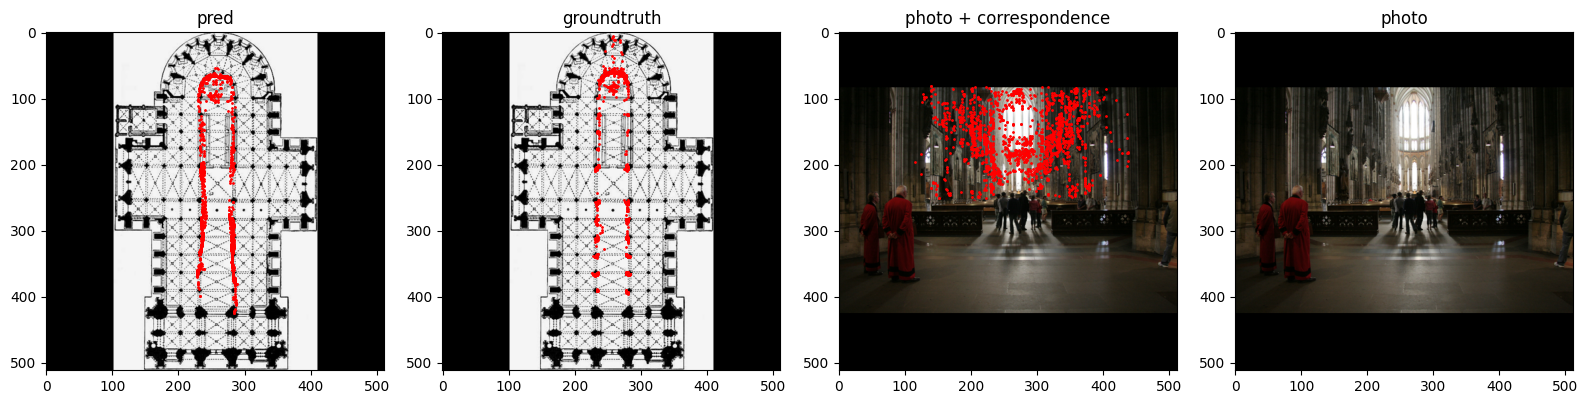

Building Train (heldout)/Test Data loader for dataset
Train (heldout)/Test dataset length: 1


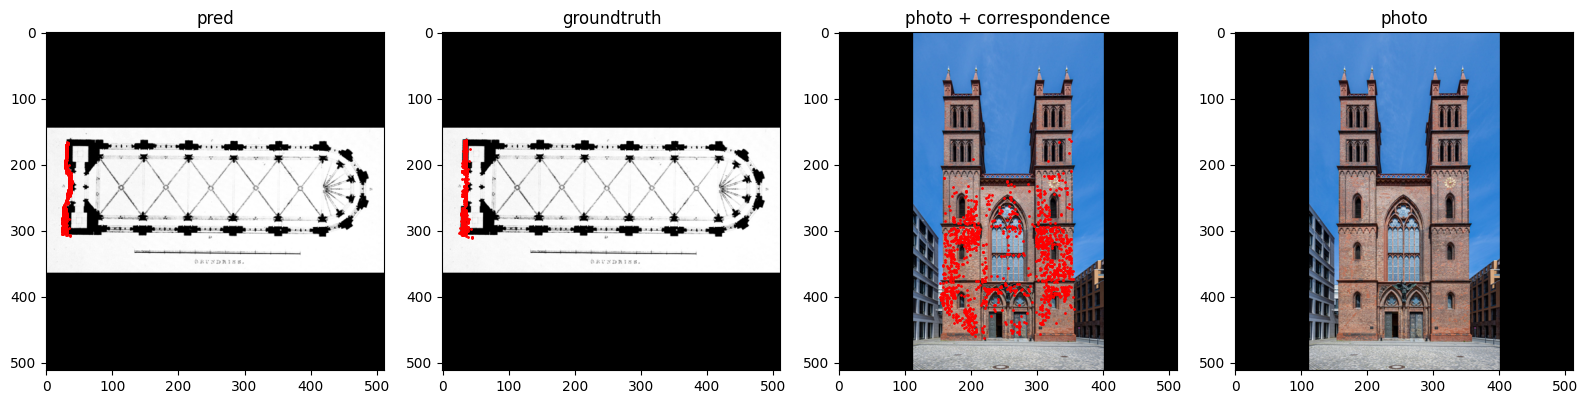

Building Train (heldout)/Test Data loader for dataset
Train (heldout)/Test dataset length: 1


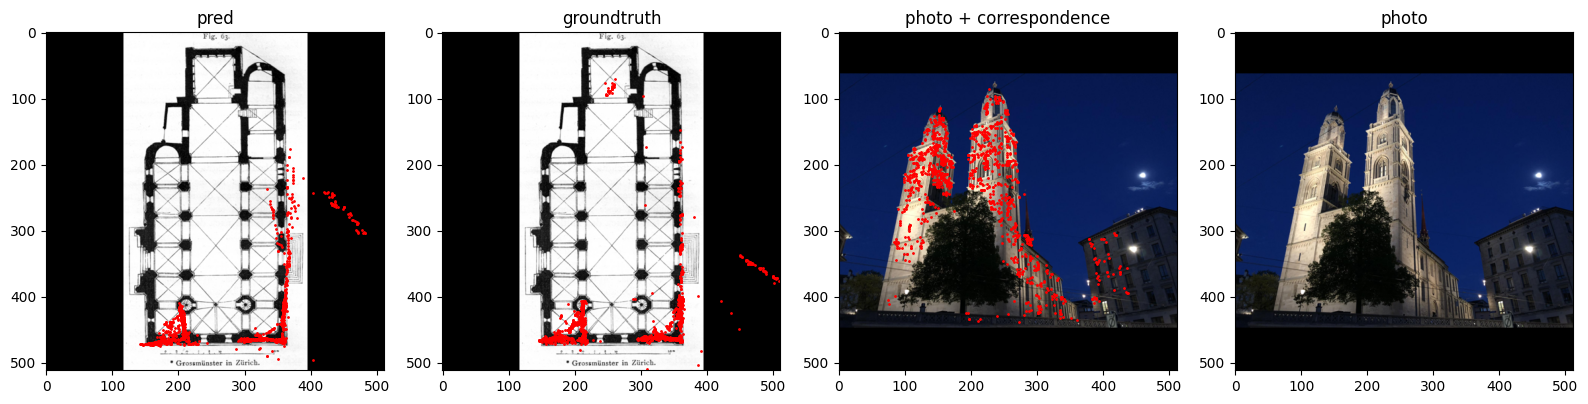

Building Train (heldout)/Test Data loader for dataset
Train (heldout)/Test dataset length: 1


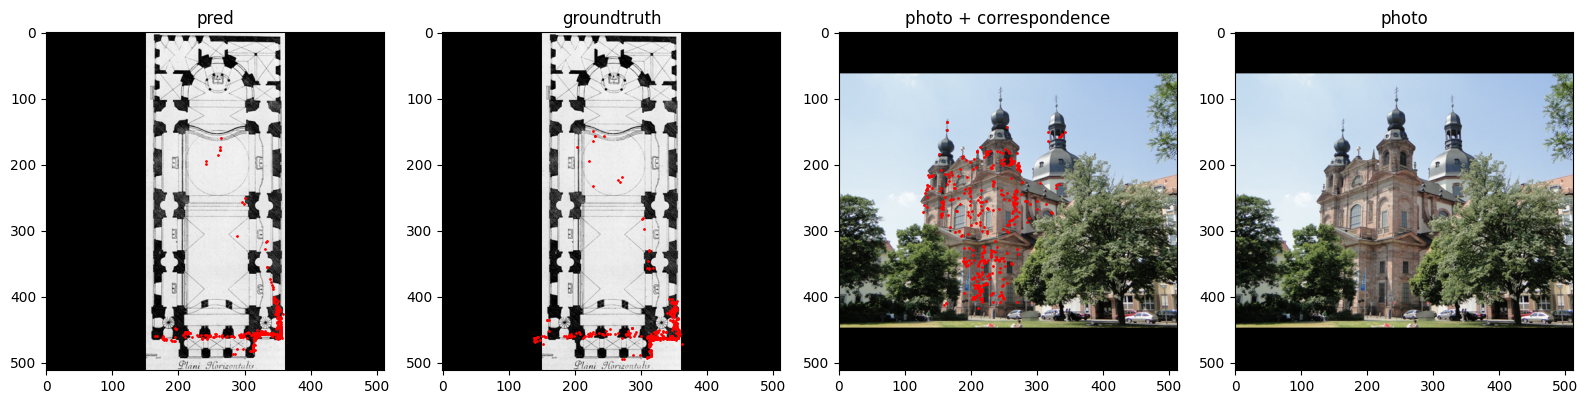

Building Train (heldout)/Test Data loader for dataset
Train (heldout)/Test dataset length: 1


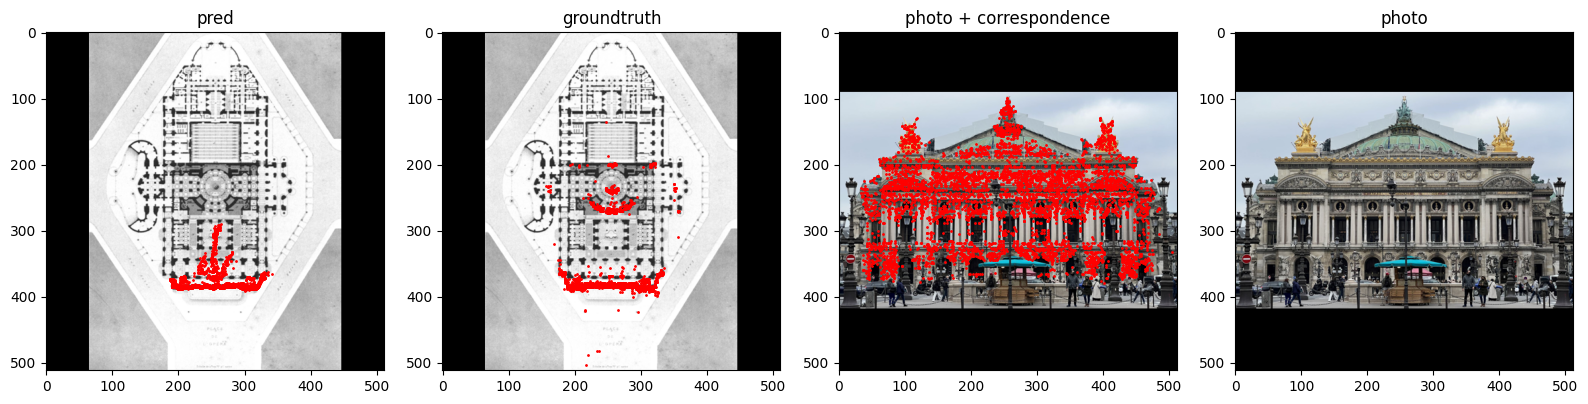

Building Train (heldout)/Test Data loader for dataset
Train (heldout)/Test dataset length: 1


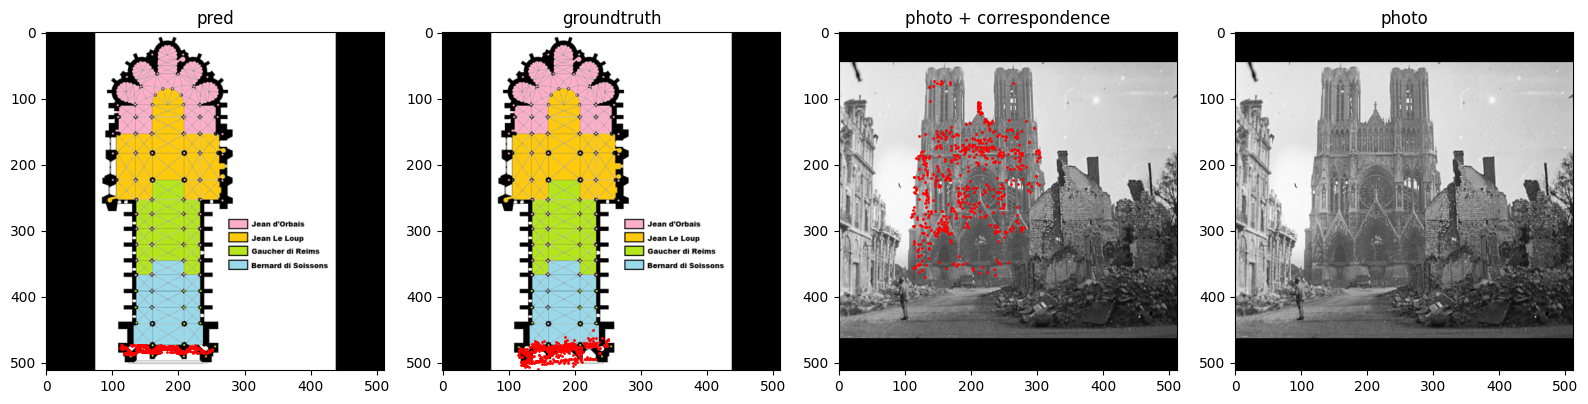

Building Train (heldout)/Test Data loader for dataset
Train (heldout)/Test dataset length: 1


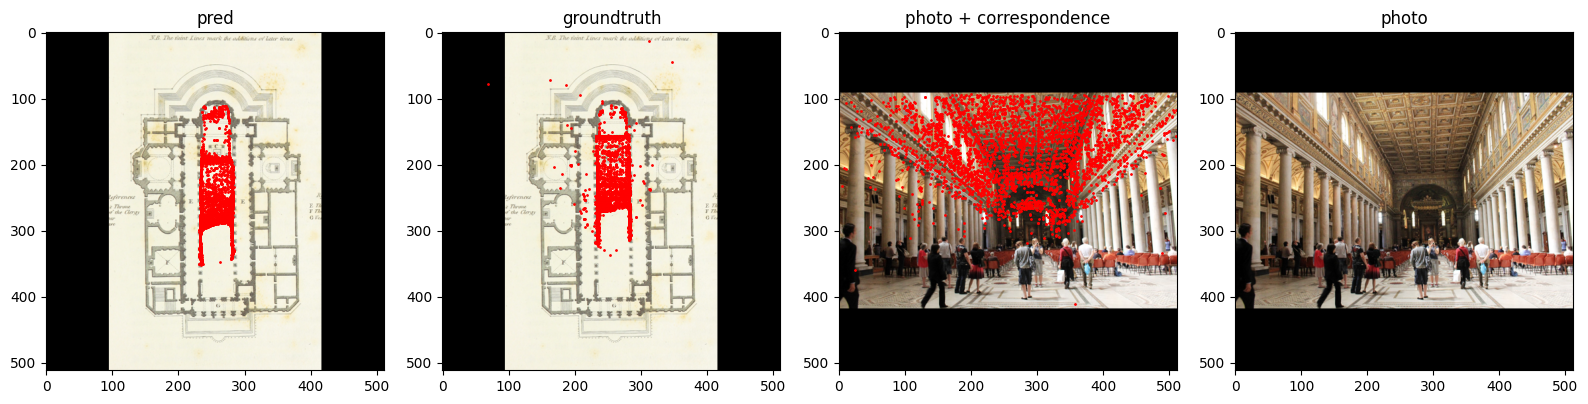

Building Train (heldout)/Test Data loader for dataset
Train (heldout)/Test dataset length: 1


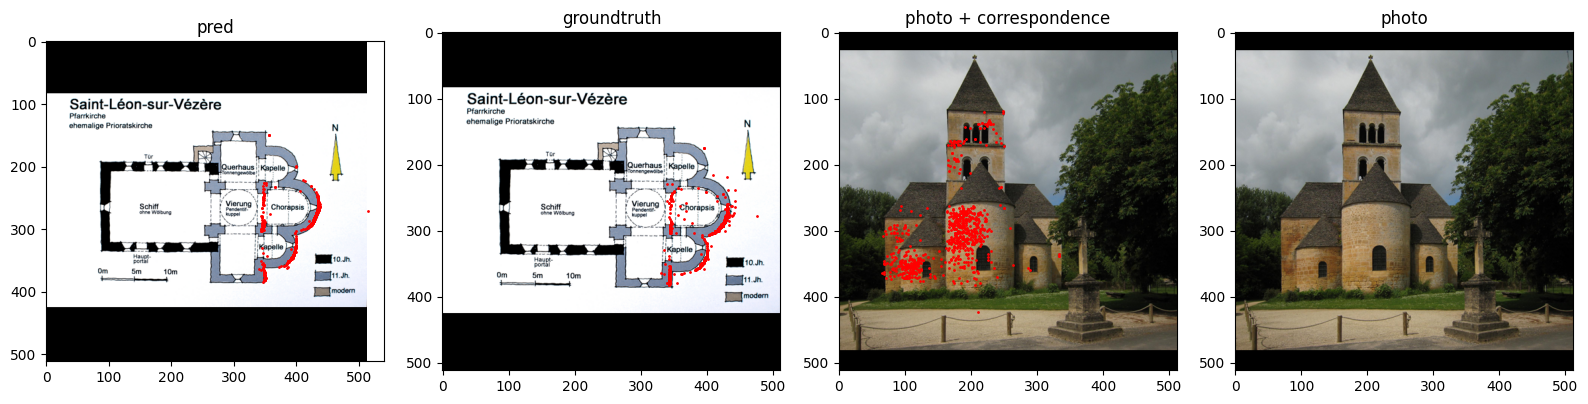

In [4]:
ids = [i.replace(".npy", "") for i in sorted(listdir(join(demo_dir, "correspondences")))]
for id in ids:
    plan_path = join(demo_dir, "images", "plans", f"{id}_plan.jpg")
    photo_path = join(demo_dir, "images", "photos", f"{id}_photo.jpg")
    cor_path = join(demo_dir, "correspondences", f"{id}.npy")
    batches = make_batches(plan_path, photo_path, cor_path, batch_size=1)
    for batch in batches:
        output = loss_of_one_batch(
            batch, 
            model=model, 
            criterion=criterion, 
            device=device, 
            symmetrize_batch=False, 
            use_amp=False, 
            ret=None
        )
        view1 = output["view1"]
        view2 = output["view2"]
        pred1 = output["pred1"]
        pred2 = output["pred2"]

        viz(view1, view2, pred1, pred2, image_size=image_size)
